<a href="https://colab.research.google.com/github/shoreey/Air-Quality-Analysis-for-Local-Government/blob/main/Natural_Disaster_Prediction_with_Satellite_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Natural Disaster

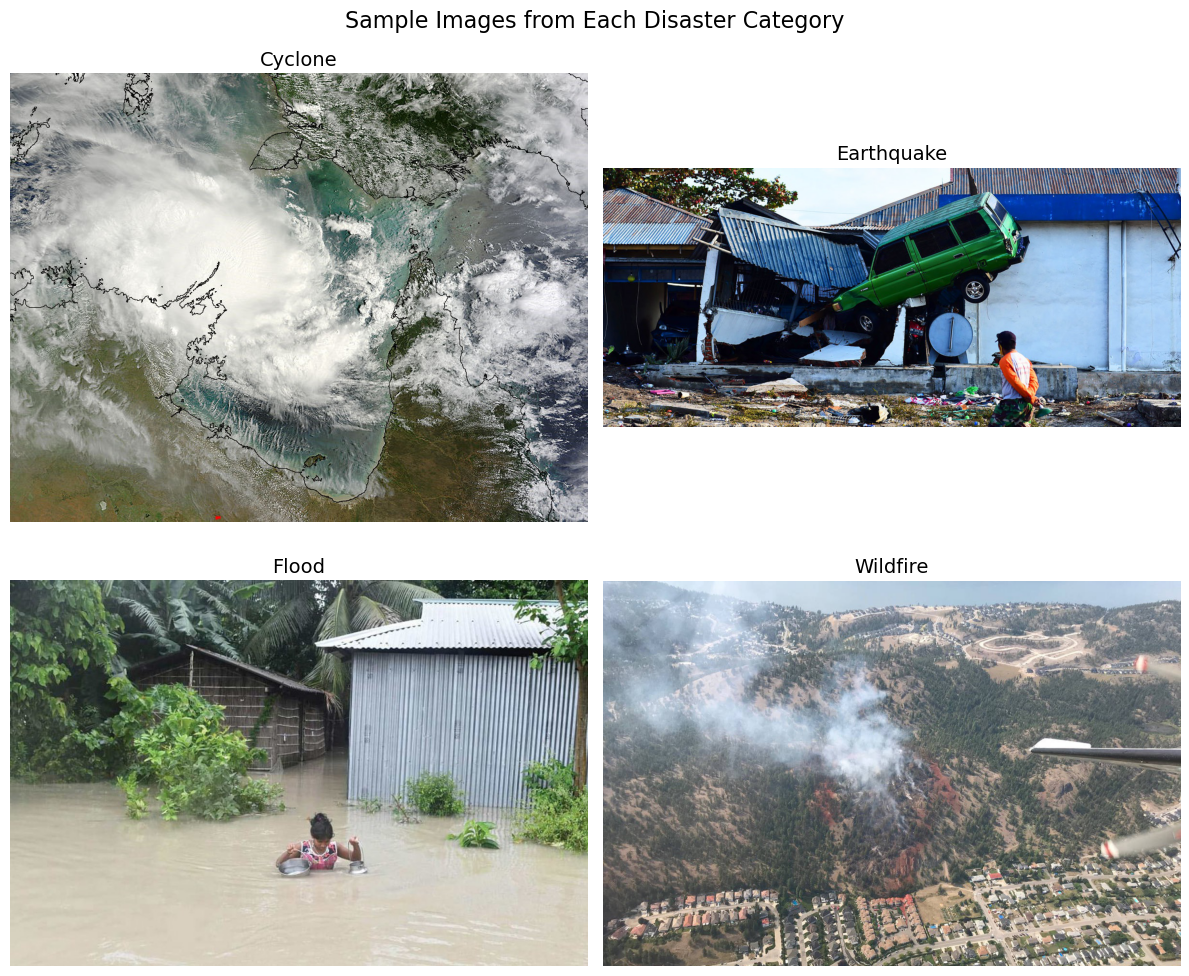

Cyclone: 928 images
Earthquake: 1350 images
Flood: 1073 images
Wildfire: 1077 images


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

# Set the directory path
dir_path = r"Cyclone_Wildfire_Flood_Earthquake_Database"

# Get a list of subfolders
subfolders = [f.path for f in os.scandir(dir_path) if f.is_dir()]

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Flatten the axes array

# Loop through each subfolder and plot a random image
for i, subfolder in enumerate(subfolders):
    # Get a list of image files in the subfolder
    files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # If there are image files in the subfolder
    if files:
        # Get a random file path
        random_file = random.choice(files)

        # Open and plot the random image
        image = Image.open(random_file)
        axes[i].imshow(image)
        axes[i].set_title(os.path.basename(subfolder), fontsize=14)
        axes[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Add a main title
plt.suptitle("Sample Images from Each Disaster Category", fontsize=16, y=1.02)

# Save the figure
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Print some statistics
for subfolder in subfolders:
    num_images = len([f for f in os.scandir(subfolder) if f.is_file() and f.name.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(f"{os.path.basename(subfolder)}: {num_images} images")

In [ ]:
import os
import numpy as np
import cv2  # Add this import
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, multiply, Activation, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import json


# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []
    class_names = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images(dir_path)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Attention mechanism
def attention_module(x, ratio=8):
    channel = x.shape[-1]

    # Channel attention
    avg_pool = GlobalAveragePooling2D()(x)
    avg_pool = Dense(channel // ratio, activation='relu')(avg_pool)
    avg_pool = Dense(channel, activation='sigmoid')(avg_pool)

    # Spatial attention
    max_pool = MaxPooling2D(pool_size=(2, 2))(x)
    max_pool = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(max_pool)
    max_pool = UpSampling2D()(max_pool)

    # Multiply
    channel_att = multiply([x, avg_pool[:, None, None, :]])
    spatial_att = multiply([channel_att, max_pool])

    return spatial_att

# Advanced CNN model with attention
def create_model():
    inputs = Input(shape=(224, 224, 3))

    x = Conv2D(64, kernel_size=3, activation='relu')(inputs)
    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, kernel_size=3, activation='relu')(x)
    x = Conv2D(128, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, kernel_size=3, activation='relu')(x)
    x = Conv2D(256, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = attention_module(x)

    x = Conv2D(512, kernel_size=3, activation='relu')(x)
    x = Conv2D(512, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, subset='training'),
    validation_data=datagen.flow(X_train, y_train, batch_size=32, subset='validation'),
    epochs=20,
    callbacks=[early_stop]
)

# Save the model
model.save('disaster_detection_model.h5')
print("Model saved as 'disaster_detection_model.h5'")

# Save the model weights
model.save_weights('disaster_detection_weights.h5')
print("Model weights saved as 'disaster_detection_weights.h5'")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# ROC Curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

# Training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Print final metrics
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Save training history
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)
print("Training history saved as 'training_history.json'")

C:\Users\shaur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 507s 6s/step - accuracy: 0.2811 - loss: 8.4532 - val_accuracy: 0.2218 - val_loss: 1.3822
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 766s 9s/step - accuracy: 0.3586 - loss: 1.3031 - val_accuracy: 0.3799 - val_loss: 1.3441
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 674s 8s/step - accuracy: 0.3911 - loss: 1.2823 - val_accuracy: 0.4477 - val_loss: 1.3527
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.4560 - loss: 1.1881 - val_accuracy: 0.5494 - val_loss: 1.0646
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 484s 5s/step - accuracy: 0.4885 - loss: 1.1213 - val_accuracy: 0.5621 - val_loss: 1.0156
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 603s 7s/step - accuracy: 0.5417 - loss: 1.0339 - val_accuracy: 0.5833 - val_loss: 0.9822
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 914s 10s/step - accuracy: 0.5677 - loss: 0.9634 - val_accuracy: 0.5918 - val_loss: 0.8750
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 893s 10s/step - accuracy: 0.6033 - loss: 0.9284 - val_accuracy: 0.6158 -

Model saved as 'disaster_detection_model.h5'


ValueError: The filename must end in `.weights.h5`. Received: filepath=disaster_detection_weights.h5

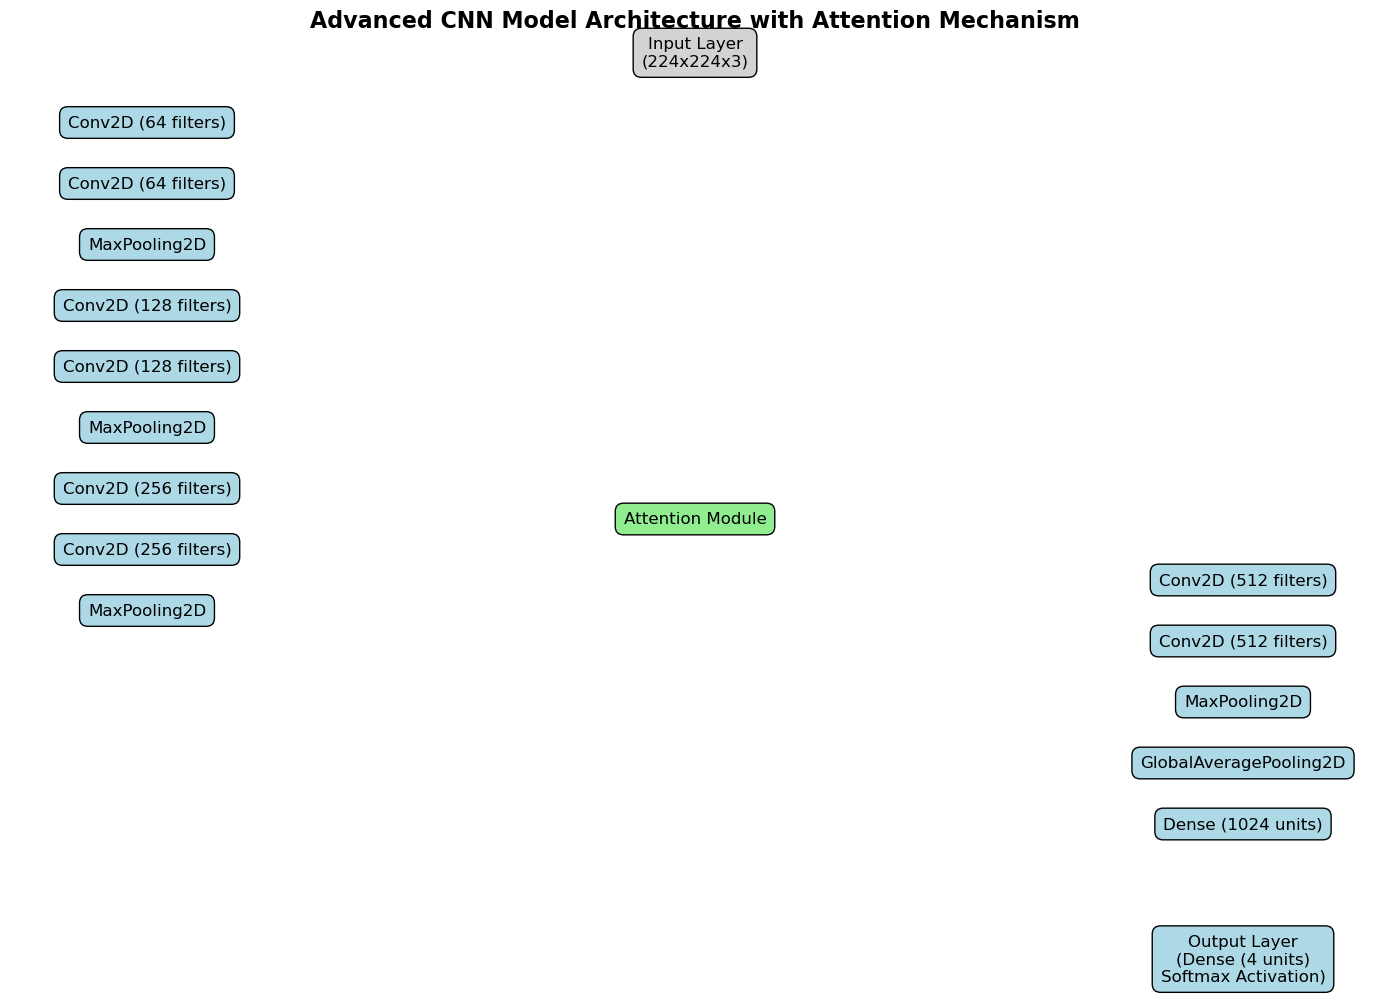

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 1)
ax.axis('off')

# Title
plt.title('Advanced CNN Model Architecture with Attention Mechanism', fontsize=16, fontweight='bold')

# Input Layer
ax.text(0.5, 0.95, 'Input Layer\n(224x224x3)', fontsize=12, ha='center',
        bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.5'))

# Convolutional Layers
conv_layers = [
    ('Conv2D (64 filters)', 0.85),
    ('Conv2D (64 filters)', 0.75),
    ('MaxPooling2D', 0.65),
    ('Conv2D (128 filters)', 0.55),
    ('Conv2D (128 filters)', 0.45),
    ('MaxPooling2D', 0.35),
    ('Conv2D (256 filters)', 0.25),
    ('Conv2D (256 filters)', 0.15),
    ('MaxPooling2D', 0.05),
]

for i, (layer_name, y_position) in enumerate(conv_layers):
    ax.text(0.1, y_position, layer_name, fontsize=12,
            ha='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Attention Module
ax.text(0.5, 0.20, 'Attention Module', fontsize=12,
        ha='center', bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='round,pad=0.5'))

# More Convolutional Layers after Attention
post_attention_layers = [
    ('Conv2D (512 filters)', 0.10),
    ('Conv2D (512 filters)', 0.00),
    ('MaxPooling2D', -0.10),
]

for i, (layer_name, y_position) in enumerate(post_attention_layers):
    ax.text(0.9, y_position, layer_name, fontsize=12,
            ha='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Global Average Pooling Layer
ax.text(0.9, -0.20, 'GlobalAveragePooling2D', fontsize=12,
        ha='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Dense Layers
dense_layers = [
    ('Dense (1024 units)', -0.30),
    ('Output Layer\n(Dense (4 units)\nSoftmax Activation)', -0.40)
]

for i, (layer_name, y_position) in enumerate(dense_layers):
    ax.text(0.9, y_position - i * 0.15, layer_name, fontsize=12,
            ha='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Layout adjustments for clarity
plt.tight_layout()
plt.savefig('advanced_cnn_model_architecture_clean.png', bbox_inches='tight')
plt.show()

In [ ]:
model.save('disaster_detection_model.keras')
print("Model saved as 'disaster_detection_model.keras'")

Model saved as 'disaster_detection_model.keras'


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 895ms/step - accuracy: 0.8737 - loss: 0.3692
Test accuracy: 0.8499


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

# Register the custom layer (attention_module)
get_custom_objects().update({'attention_module': attention_module})

# Load the full model (architecture + weights)
model = load_model('disaster_detection_model.keras', custom_objects={'attention_module': attention_module})
print("Model loaded from 'disaster_detection_model.keras'")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Model loaded from 'disaster_detection_model.keras'
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 898ms/step - accuracy: 0.8737 - loss: 0.3692
Test accuracy: 0.8499


28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 953ms/step


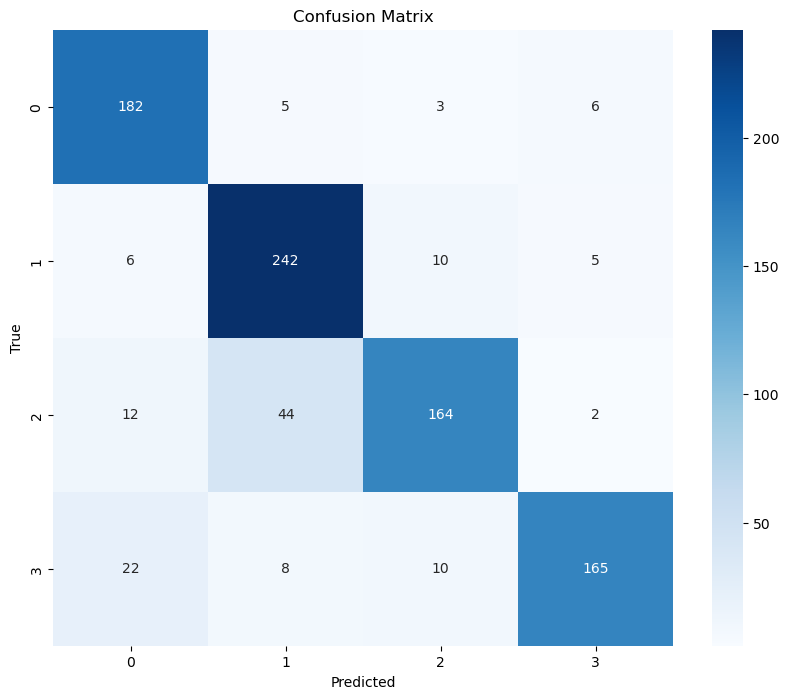

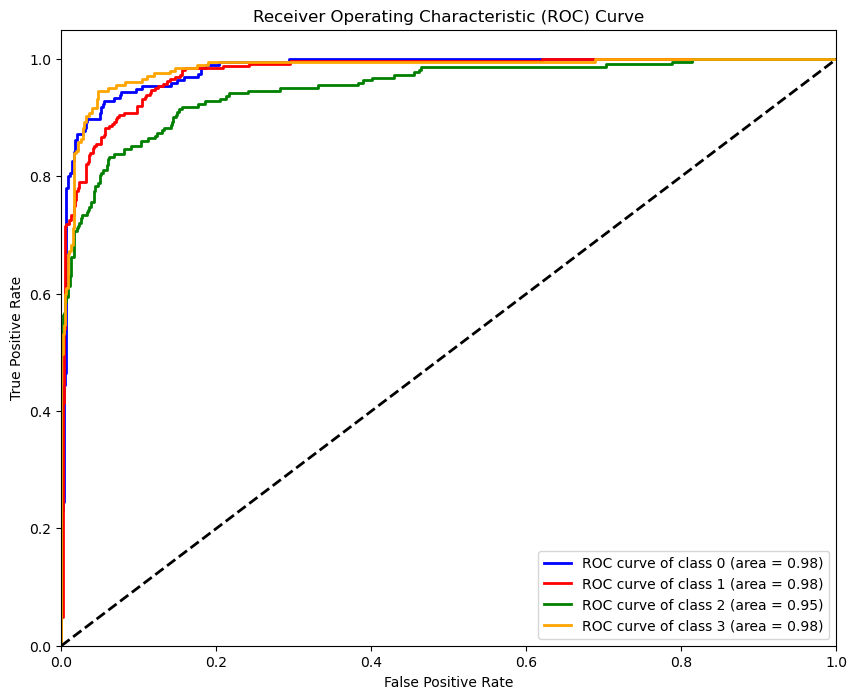

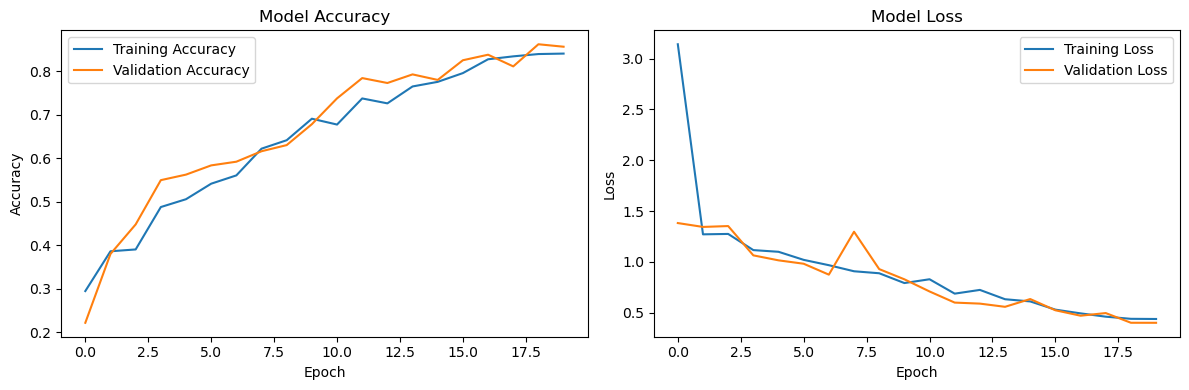

Final training accuracy: 0.8402
Final validation accuracy: 0.8559
Final training loss: 0.4390
Final validation loss: 0.4015
Training history saved as 'training_history.json'


In [ ]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# ROC Curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

# Training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Print final metrics
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Save training history
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)
print("Training history saved as 'training_history.json'")

In [ ]:
# Print Confusion Matrix
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[182   5   3   6]
 [  6 242  10   5]
 [ 12  44 164   2]
 [ 22   8  10 165]]


Model loaded from 'disaster_detection_model.keras'


C:\Users\shaur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 475s 5s/step - accuracy: 0.8718 - loss: 0.3485 - val_accuracy: 0.8588 - val_loss: 0.3928
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 475s 5s/step - accuracy: 0.8960 - loss: 0.3109 - val_accuracy: 0.8757 - val_loss: 0.3307
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 482s 5s/step - accuracy: 0.9033 - loss: 0.2898 - val_accuracy: 0.8842 - val_loss: 0.3584
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.9032 - loss: 0.2711 - val_accuracy: 0.8870 - val_loss: 0.3377
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 486s 5s/step - accuracy: 0.9062 - loss: 0.2698 - val_accuracy: 0.8856 - val_loss: 0.3390
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 458s 5s/step - accuracy: 0.9087 - loss: 0.2619 - val_accuracy: 0.8828 - val_loss: 0.3301
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 478s 5s/step - accuracy: 0.9144 - loss: 0.2533 - val_accuracy: 0.8969 - val_loss: 0.3243
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 457s 5s/step - accuracy: 0.9073 - loss: 0.2560 - val_accuracy: 0.8941 - v

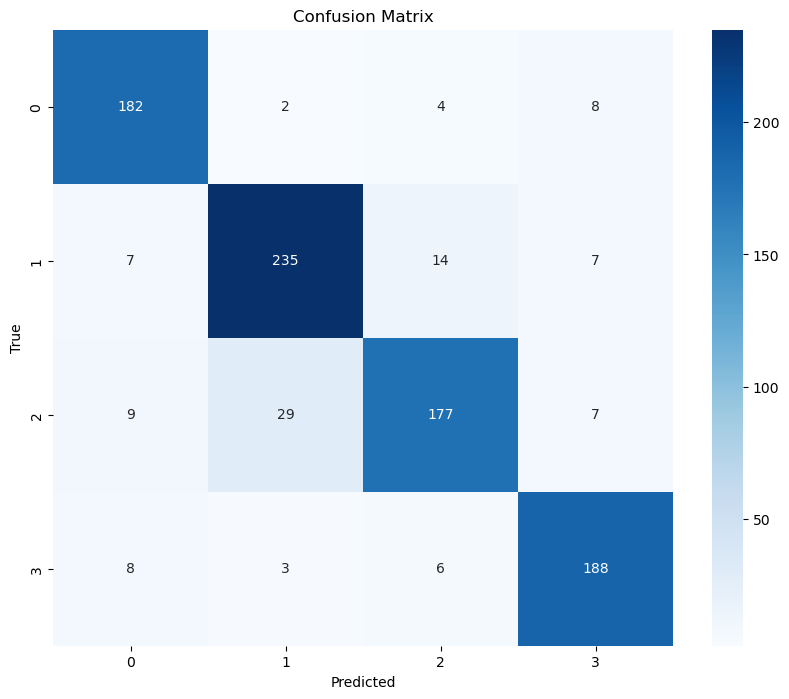


Classification Report:
              precision    recall  f1-score   support

     Cyclone       0.88      0.93      0.91       196
  Earthquake       0.87      0.89      0.88       263
       Flood       0.88      0.80      0.84       222
    Wildfire       0.90      0.92      0.91       205

    accuracy                           0.88       886
   macro avg       0.88      0.88      0.88       886
weighted avg       0.88      0.88      0.88       886



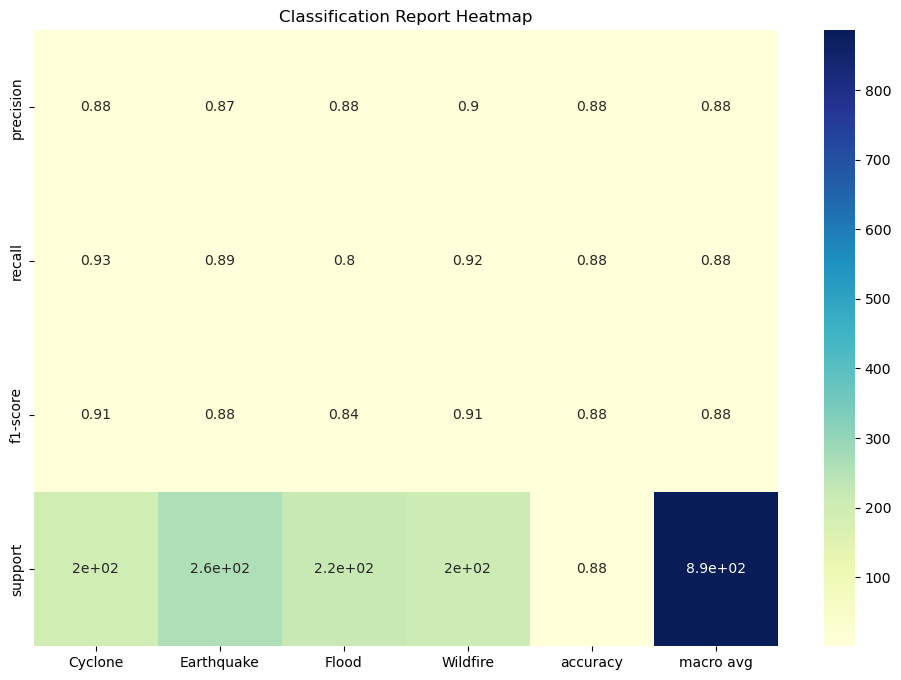

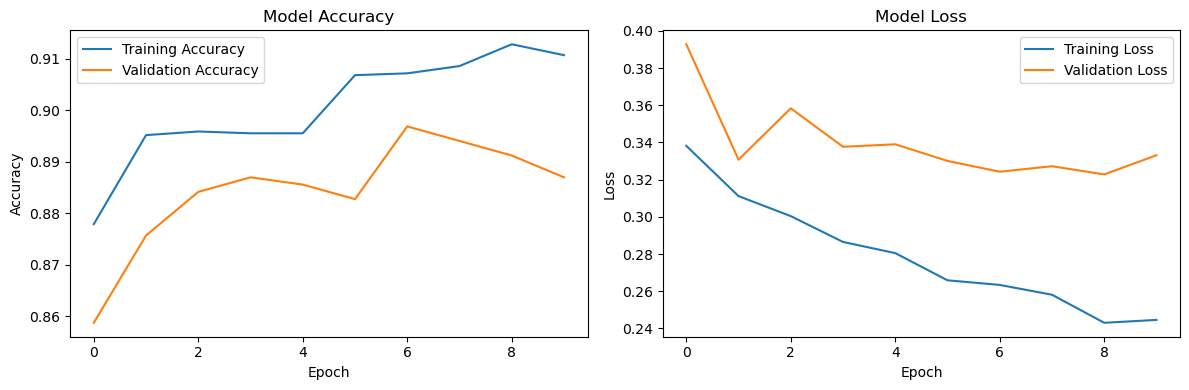


Final training accuracy: 0.9107
Final validation accuracy: 0.8870
Final training loss: 0.2446
Final validation loss: 0.3331


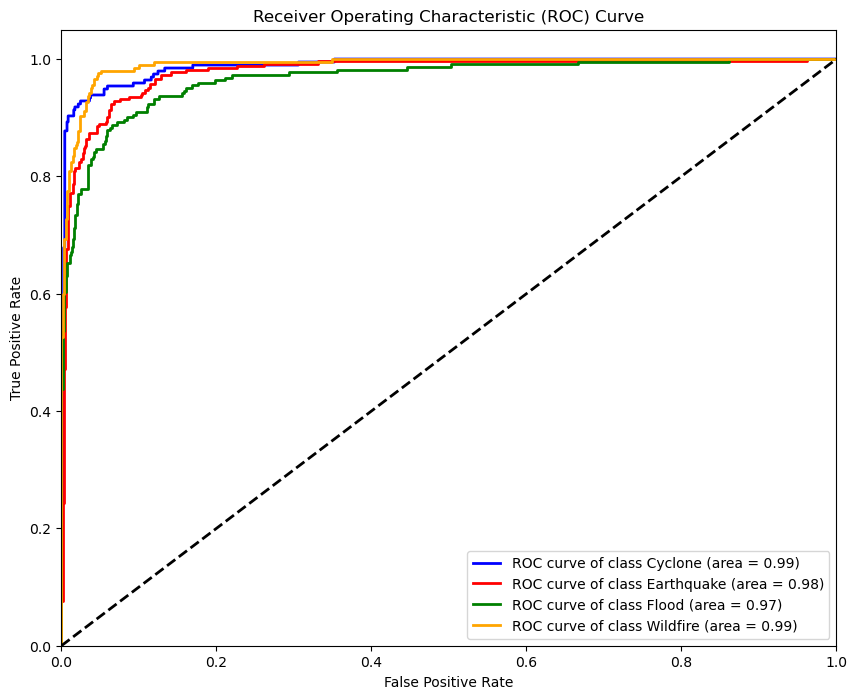

Training history saved as 'training_history.json'


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, multiply, Activation, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import pandas as pd

# Load the saved model
model = load_model('disaster_detection_model.keras', custom_objects={'attention_module': attention_module})
print("Model loaded from 'disaster_detection_model.keras'")


# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []
    class_names = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images(dir_path)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('disaster_detection_model_improved.keras',
                             save_best_only=True,
                             monitor='val_accuracy',
                             mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Continue training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, subset='training'),
    validation_data=datagen.flow(X_train, y_train, batch_size=32, subset='validation'),
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Updated test accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification Report
class_names = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
cr = classification_report(y_test, y_pred_classes, target_names=class_names)
print("\nClassification Report:")
print(cr)

# Plot Classification Report
cr_dict = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)
cr_df = pd.DataFrame(cr_dict).transpose()
plt.figure(figsize=(12, 8))
sns.heatmap(cr_df.iloc[:-1, :].T, annot=True, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.savefig('classification_report.png')
plt.show()

# Training History Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Print final metrics
print(f"\nFinal training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

# ROC Curve and AUC
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

# Save training history
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)
print("Training history saved as 'training_history.json'")

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []
    class_names = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images(dir_path)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('disaster_detection_model_vgg16.keras',
                             save_best_only=True,
                             monitor='val_accuracy',
                             mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, subset='training'),
    validation_data=datagen.flow(X_train, y_train, batch_size=32, subset='validation'),
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_vgg16.png')
plt.show()

# Classification Report
class_names = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
cr = classification_report(y_test, y_pred_classes, target_names=class_names)
print("\nClassification Report:")
print(cr)

# Training History Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history_vgg16.png')
plt.show()

# ROC Curve and AUC
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_vgg16.png')
plt.show()

# Save training history

C:\Users\shaur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.6449 - loss: 1.1825 - val_accuracy: 0.9025 - val_loss: 0.2432
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9011 - loss: 0.2849 - val_accuracy: 0.9167 - val_loss: 0.2398
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9291 - loss: 0.2034 - val_accuracy: 0.9011 - val_loss: 0.2779
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.9251 - loss: 0.2240 - val_accuracy: 0.9294 - val_loss: 0.2021
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.9317 - loss: 0.1804 - val_accuracy: 0.9421 - val_loss: 0.1745
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9485 - loss: 0.1456 - val_accuracy: 0.9364 - val_loss: 0.1909
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9387 - loss: 0.1580 - val_accuracy: 0.9379 - val_loss: 0.1879
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9551 - loss: 0.1300 - val_accuracy: 0.9379 - v

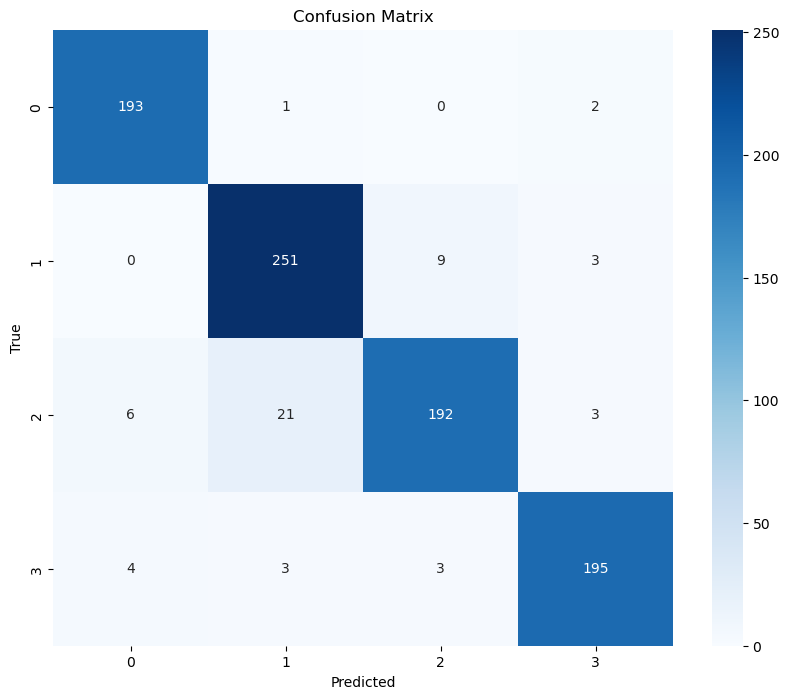


Classification Report:
              precision    recall  f1-score   support

     Cyclone       0.95      0.98      0.97       196
  Earthquake       0.91      0.95      0.93       263
       Flood       0.94      0.86      0.90       222
    Wildfire       0.96      0.95      0.96       205

    accuracy                           0.94       886
   macro avg       0.94      0.94      0.94       886
weighted avg       0.94      0.94      0.94       886



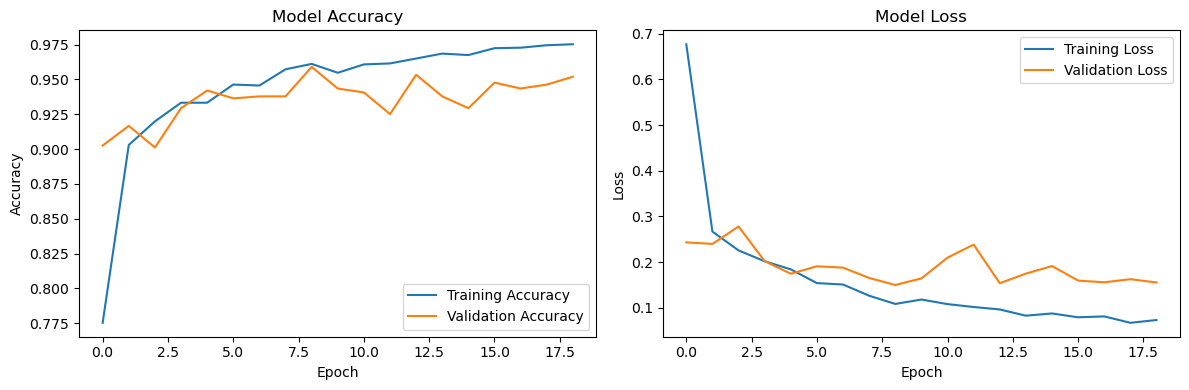

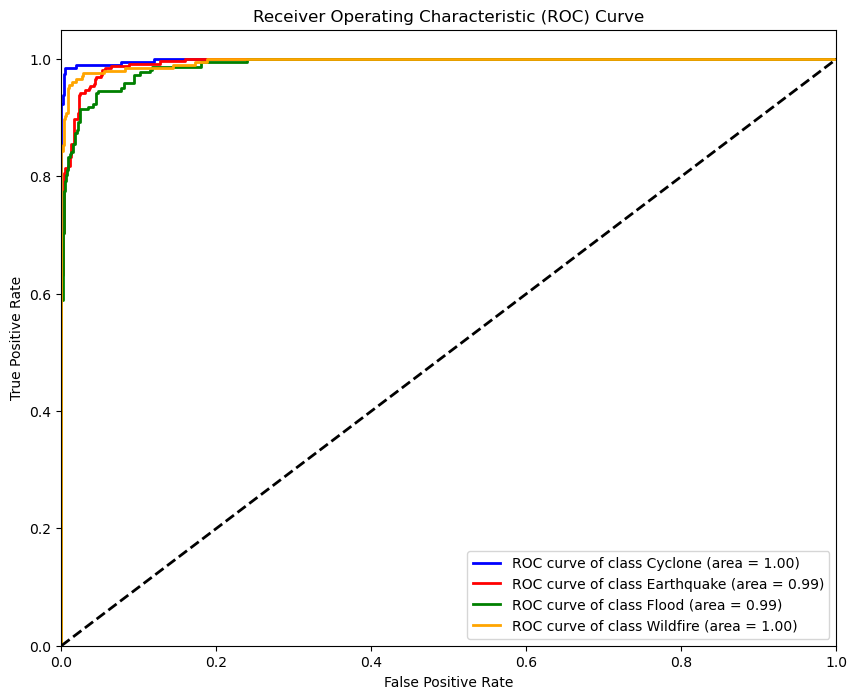

Training history saved as 'training_history_vgg16.json'


In [ ]:
with open('training_history_vgg16.json', 'w') as f:
    json.dump(history.history, f)
print("Training history saved as 'training_history_vgg16.json'")

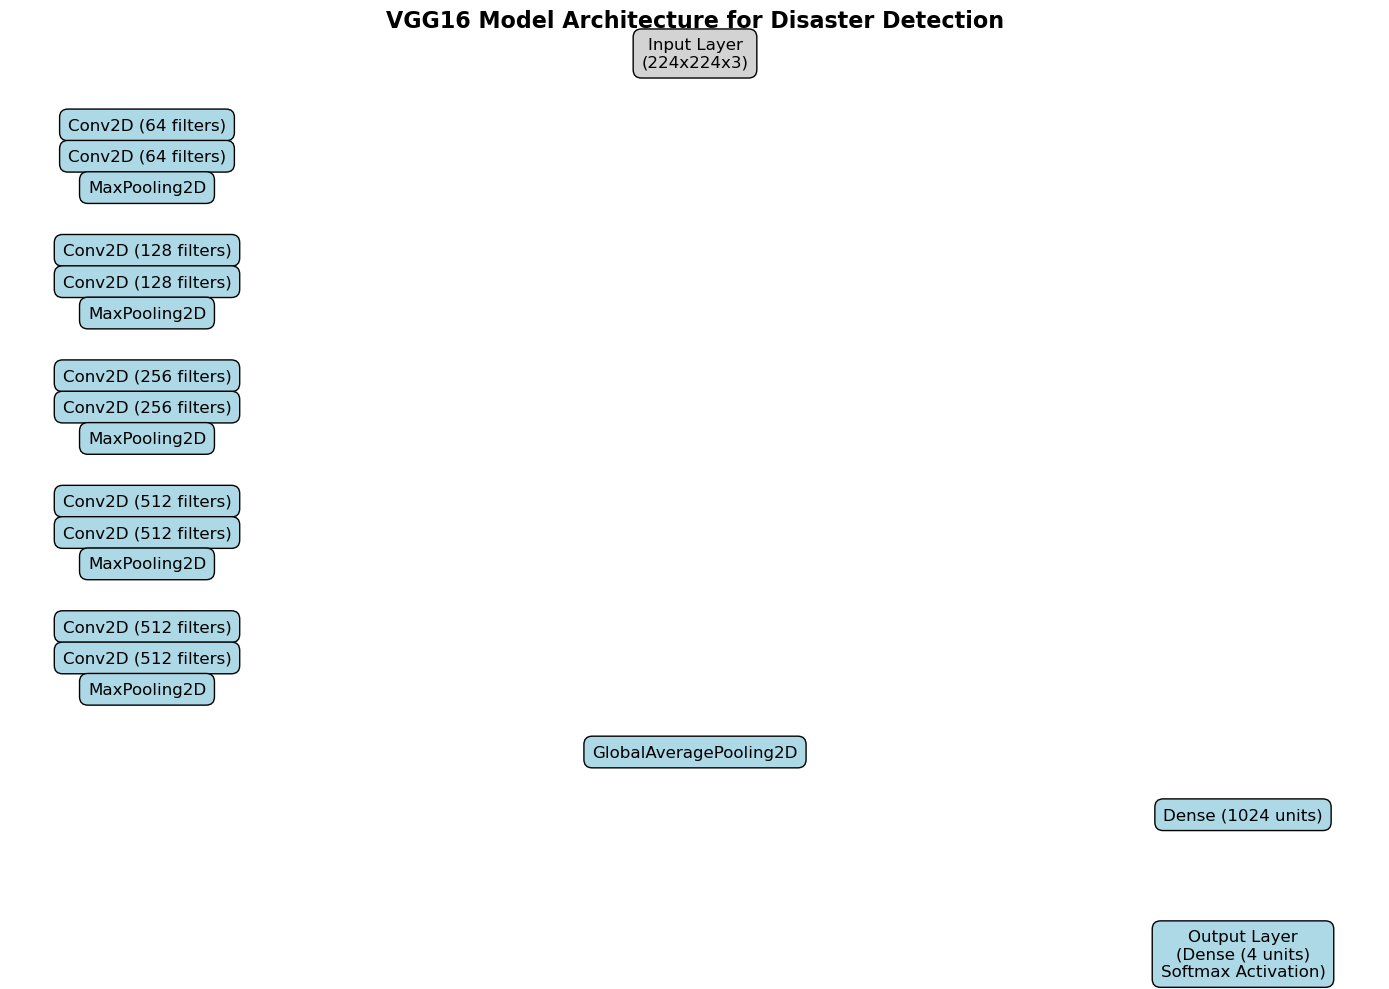

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 1)
ax.axis('off')

# Title
plt.title('VGG16 Model Architecture for Disaster Detection', fontsize=16, fontweight='bold')

# Input Layer
ax.text(0.5, 0.95, 'Input Layer\n(224x224x3)', fontsize=12, ha='center',
        bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.5'))

# VGG16 Convolutional Layers
vgg_layers = [
    ('Conv2D (64 filters)', 0.85),
    ('Conv2D (64 filters)', 0.80),
    ('MaxPooling2D', 0.75),
    ('Conv2D (128 filters)', 0.65),
    ('Conv2D (128 filters)', 0.60),
    ('MaxPooling2D', 0.55),
    ('Conv2D (256 filters)', 0.45),
    ('Conv2D (256 filters)', 0.40),
    ('MaxPooling2D', 0.35),
    ('Conv2D (512 filters)', 0.25),
    ('Conv2D (512 filters)', 0.20),
    ('MaxPooling2D', 0.15),
    ('Conv2D (512 filters)', 0.05),
    ('Conv2D (512 filters)', 0.00),
    ('MaxPooling2D', -0.05)
]

for layer_name, y_position in vgg_layers:
    ax.text(0.1, y_position, layer_name, fontsize=12,
            ha='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Global Average Pooling Layer
ax.text(0.5, -0.15, 'GlobalAveragePooling2D', fontsize=12,
        ha='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Dense Layers
dense_layers = [
    ('Dense (1024 units)', -0.25),
    ('Output Layer\n(Dense (4 units)\nSoftmax Activation)', -0.35)
]

for i, (layer_name, y_position) in enumerate(dense_layers):
    ax.text(0.9, y_position - i * 0.15, layer_name, fontsize=12,
            ha='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Layout adjustments for clarity
plt.tight_layout()
plt.savefig('vgg16_model_architecture.png', bbox_inches='tight')
plt.show()


Training fold 1...


C:\Users\shaur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.9477 - loss: 0.1413 - val_accuracy: 0.9108 - val_loss: 0.2307
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.9490 - loss: 0.1508 - val_accuracy: 0.9221 - val_loss: 0.2035
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.9556 - loss: 0.1193 - val_accuracy: 0.9278 - val_loss: 0.2148
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.9651 - loss: 0.1051 - val_accuracy: 0.9312 - val_loss: 0.2136
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.9553 - loss: 0.1284 - val_accuracy: 0.9312 - val_loss: 0.2055
28/28 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9404 - loss: 0.2024
Fold 1 accuracy: 0.9312
28/28 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

Confusion Matrix for fold 1:
[[192   0   1   3]
 [  4 233  24   2]
 [  1  10 201  10]
 [  3   1   7 194]]

Classification Report for fold 1:
              precision    recall  f1-score   support

     Cyclone       0.9

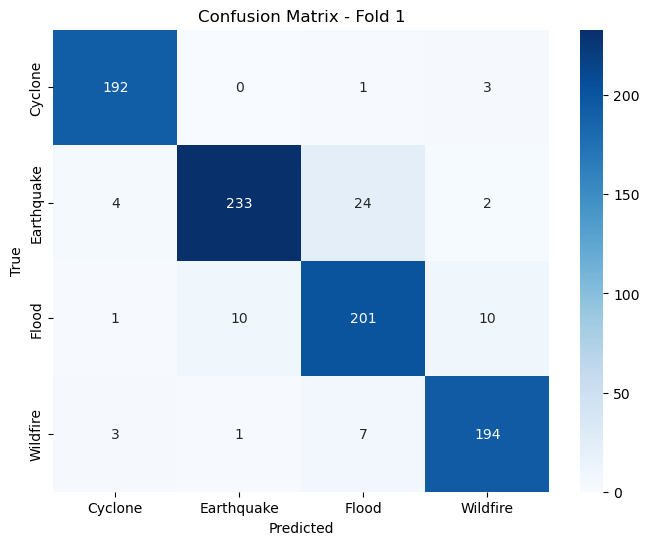


Training fold 2...


C:\Users\shaur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9563 - loss: 0.1320 - val_accuracy: 0.9470 - val_loss: 0.1654
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.9555 - loss: 0.1453 - val_accuracy: 0.9357 - val_loss: 0.1833
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9483 - loss: 0.1441 - val_accuracy: 0.9153 - val_loss: 0.2287
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.9558 - loss: 0.1238 - val_accuracy: 0.9447 - val_loss: 0.1713
28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9502 - loss: 0.1275
Fold 2 accuracy: 0.9368
28/28 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

Confusion Matrix for fold 2:
[[174   0   0   4]
 [  0 272   9   3]
 [  1  27 179   4]
 [  2   1   2 208]]

Classification Report for fold 2:
              precision    recall  f1-score   support

     Cyclone       0.98      0.98      0.98       178
  Earthquake       0.91      0.96      0.93       284
       Flood       0.94      0.85      0.89

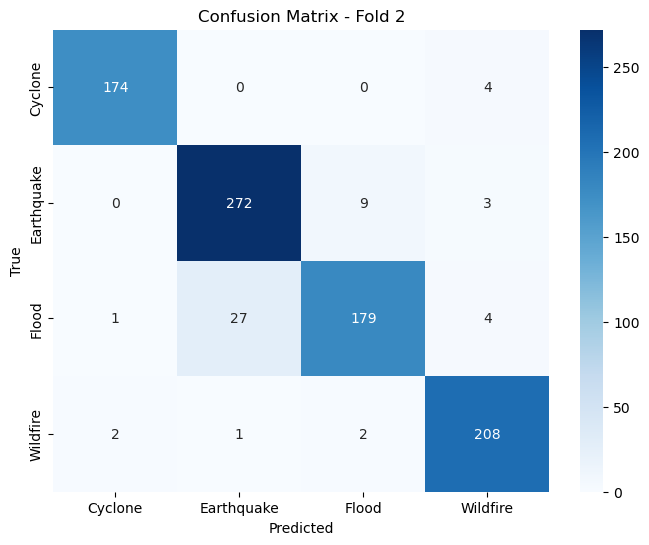


Training fold 3...


C:\Users\shaur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9420 - loss: 0.1680 - val_accuracy: 0.9424 - val_loss: 0.1480
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9456 - loss: 0.1529 - val_accuracy: 0.9549 - val_loss: 0.1332
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9506 - loss: 0.1293 - val_accuracy: 0.9560 - val_loss: 0.1272
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9602 - loss: 0.1133 - val_accuracy: 0.9458 - val_loss: 0.1413
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9551 - loss: 0.1317 - val_accuracy: 0.9560 - val_loss: 0.1321
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9591 - loss: 0.1100 - val_accuracy: 0.9537 - val_loss: 0.1518
28/28 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9533 - loss: 0.1378
Fold 3 accuracy: 0.9537
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step

Confusion Matrix for fold 3:
[[178   1   1   4]
 [  0 262   9   4]
 [  0   6 193   5]
 [ 

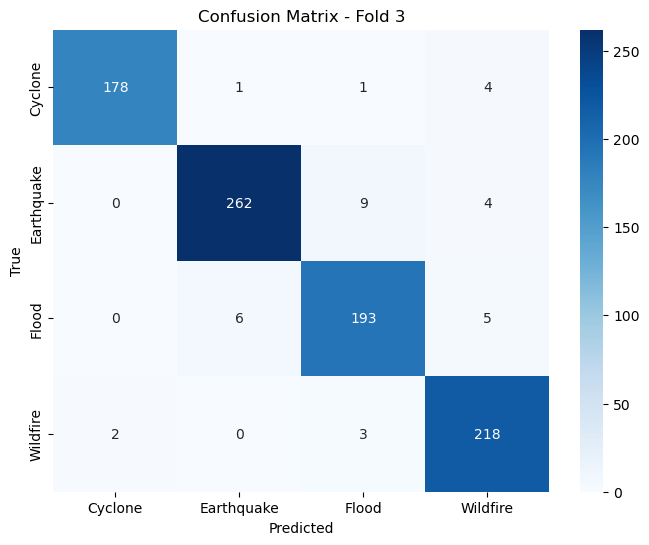


Training fold 4...


C:\Users\shaur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9463 - loss: 0.1500 - val_accuracy: 0.9458 - val_loss: 0.1568
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9498 - loss: 0.1266 - val_accuracy: 0.9469 - val_loss: 0.1390
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9516 - loss: 0.1322 - val_accuracy: 0.9412 - val_loss: 0.1688
28/28 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9268 - loss: 0.1632
Fold 4 accuracy: 0.9401
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step

Confusion Matrix for fold 4:
[[173   0   4   7]
 [  0 247  17   2]
 [  0   7 192   6]
 [  0   2   0 228]]

Classification Report for fold 4:
              precision    recall  f1-score   support

     Cyclone       1.00      0.94      0.97       184
  Earthquake       0.96      0.93      0.95       266
       Flood       0.90      0.94      0.92       205
    Wildfire       0.94      0.99      0.96       230

    accuracy                           0.95       885
   macro 

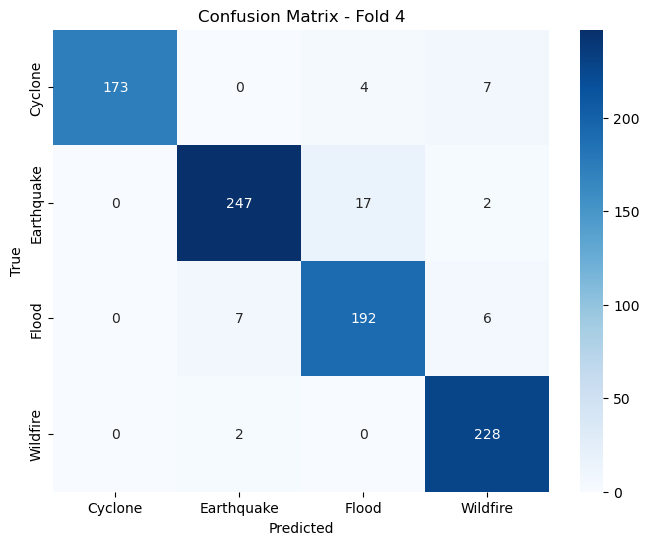


Training fold 5...


C:\Users\shaur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9415 - loss: 0.1670 - val_accuracy: 0.9480 - val_loss: 0.1507
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9489 - loss: 0.1522 - val_accuracy: 0.9435 - val_loss: 0.1643
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9626 - loss: 0.1279 - val_accuracy: 0.9469 - val_loss: 0.1575
28/28 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9626 - loss: 0.1181
Fold 5 accuracy: 0.9559
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step

Confusion Matrix for fold 5:
[[180   0   4   2]
 [  0 249   7   6]
 [  0  18 208   5]
 [  1   4   2 199]]

Classification Report for fold 5:
              precision    recall  f1-score   support

     Cyclone       0.99      0.97      0.98       186
  Earthquake       0.92      0.95      0.93       262
       Flood       0.94      0.90      0.92       231
    Wildfire       0.94      0.97      0.95       206

    accuracy                           0.94       885
   macro 

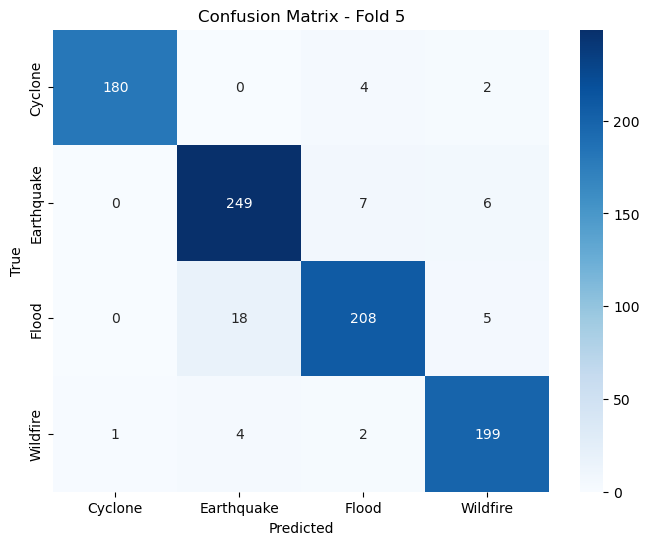


Average cross-validation accuracy: 0.9435


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []
    class_names = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images(dir_path)

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Parameters
k_folds = 5  # Number of folds for cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_accuracies = []

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(images, labels), 1):
    print(f"\nTraining fold {fold}...")

    # Split data into train and validation for this fold
    X_train, X_val = images[train_idx], images[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    # Load the saved model for each fold
    model = load_model('disaster_detection_model_vgg16.keras')

    # Apply data augmentation only on training data
    train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
    val_generator = datagen.flow(X_val, y_val, batch_size=32, shuffle=False)

    # Train the model on the current fold
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[early_stop]
    )

    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(val_generator)
    fold_accuracies.append(val_accuracy)
    print(f"Fold {fold} accuracy: {val_accuracy:.4f}")

    # Make predictions on the validation set
    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix and Classification Report for each fold
    cm = confusion_matrix(y_val, y_pred_classes)
    print(f"\nConfusion Matrix for fold {fold}:")
    print(cm)

    # Classification Report
    class_names = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
    cr = classification_report(y_val, y_pred_classes, target_names=class_names)
    print(f"\nClassification Report for fold {fold}:")
    print(cr)

    # Plot Confusion Matrix for each fold
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Calculate and display the average accuracy across all folds
avg_accuracy = np.mean(fold_accuracies)
print(f"\nAverage cross-validation accuracy: {avg_accuracy:.4f}")

#Disaster Detection App

In [ ]:
import panel as pn
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from PIL import Image
import io

# Load the trained models
model_vgg16 = load_model('disaster_detection_model_vgg16.keras')
print("VGG16 model loaded successfully.")
model_improved = load_model('disaster_detection_model_improved.keras')
print("Improved model loaded successfully.")

# Define the class names
class_names = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']

# Dictionary with disaster details
disaster_info = {
    'Cyclone': "Cyclones are intense circular storms that originate over warm tropical oceans. They can cause severe wind damage, storm surges, and flooding. Be prepared by securing property and having an evacuation plan.",
    'Earthquake': "Earthquakes are caused by sudden tectonic movements in the Earth's crust. In earthquake-prone areas, secure heavy furniture and consider building retrofits to improve structural resilience.",
    'Flood': "Floods are overflowing of water onto land. They can occur from heavy rainfall, storms, or dam breaks. If you're in a flood-prone area, know evacuation routes and have emergency supplies ready.",
    'Wildfire': "Wildfires are uncontrolled fires that spread quickly in dry areas. During wildfire season, clear dry brush around property and stay informed on fire warnings."
}

def preprocess_image(image):
    img_array = np.array(image)
    img_array = cv2.resize(img_array, (224, 224))
    img_array = img_array.astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_disaster(image, model):
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction[0])
    predicted_class = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index]
    return predicted_class, confidence, prediction[0]

file_input = pn.widgets.FileInput(accept='.jpg,.jpeg,.png', multiple=True)
model_selector = pn.widgets.Select(name='Select Model', options=['VGG16', 'Improved Model'])
predict_button = pn.widgets.Button(name='Predict Disaster', button_type='primary')
image_outputs = pn.Column()

def classify_on_click(event):
    if file_input.value:
        image_outputs.clear()
        uploaded_files = file_input.value if isinstance(file_input.value, list) else [file_input.value]

        # Select the model based on user input
        selected_model = model_vgg16 if model_selector.value == 'VGG16' else model_improved

        for file in uploaded_files:
            image = Image.open(io.BytesIO(file))
            image_output = pn.pane.Image(image, width=300)
            image_outputs.append(image_output)

            predicted_class, confidence, all_probabilities = predict_disaster(image, selected_model)

            # Result strings for the selected model
            result = f"**{model_selector.value} Prediction:** {predicted_class}\n"
            result += f"**Confidence:** {confidence:.4f}\n"
            for class_name, prob in zip(class_names, all_probabilities):
                result += f"- {class_name}: {prob:.4f}\n"

            # Educational information about the predicted disaster
            disaster_details = f"**Learn about {predicted_class}:** {disaster_info.get(predicted_class, 'No information available')}\n"

            # Combine results and educational info
            results_output = pn.Column(
                pn.pane.Markdown(result),
                pn.pane.Markdown(disaster_details)
            )
            image_outputs.append(results_output)

        output_layout.object = image_outputs
    else:
        output_layout.object = "Please upload at least one image."

predict_button.on_click(classify_on_click)

output_layout = pn.Column(pn.pane.Markdown("## Predictions"), image_outputs)

app_layout = pn.Column(
    pn.pane.Markdown("# Disaster Detection App"),
    pn.pane.Markdown("Upload one or more images of potential disaster areas:"),
    file_input,
    model_selector,
    predict_button,
    output_layout
)

pn.extension()
app_layout.servable()

VGG16 model loaded successfully.
Improved model loaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] FileInput(accept='.jpg,.jpeg,.png', multiple=True)
    [3] Select(options=['VGG16', 'Improved M...], value='VGG16')
    [4] Button(button_type='primary', name='Predict Disaster')
    [5] Column
        [0] Markdown(str)
        [1] Column()

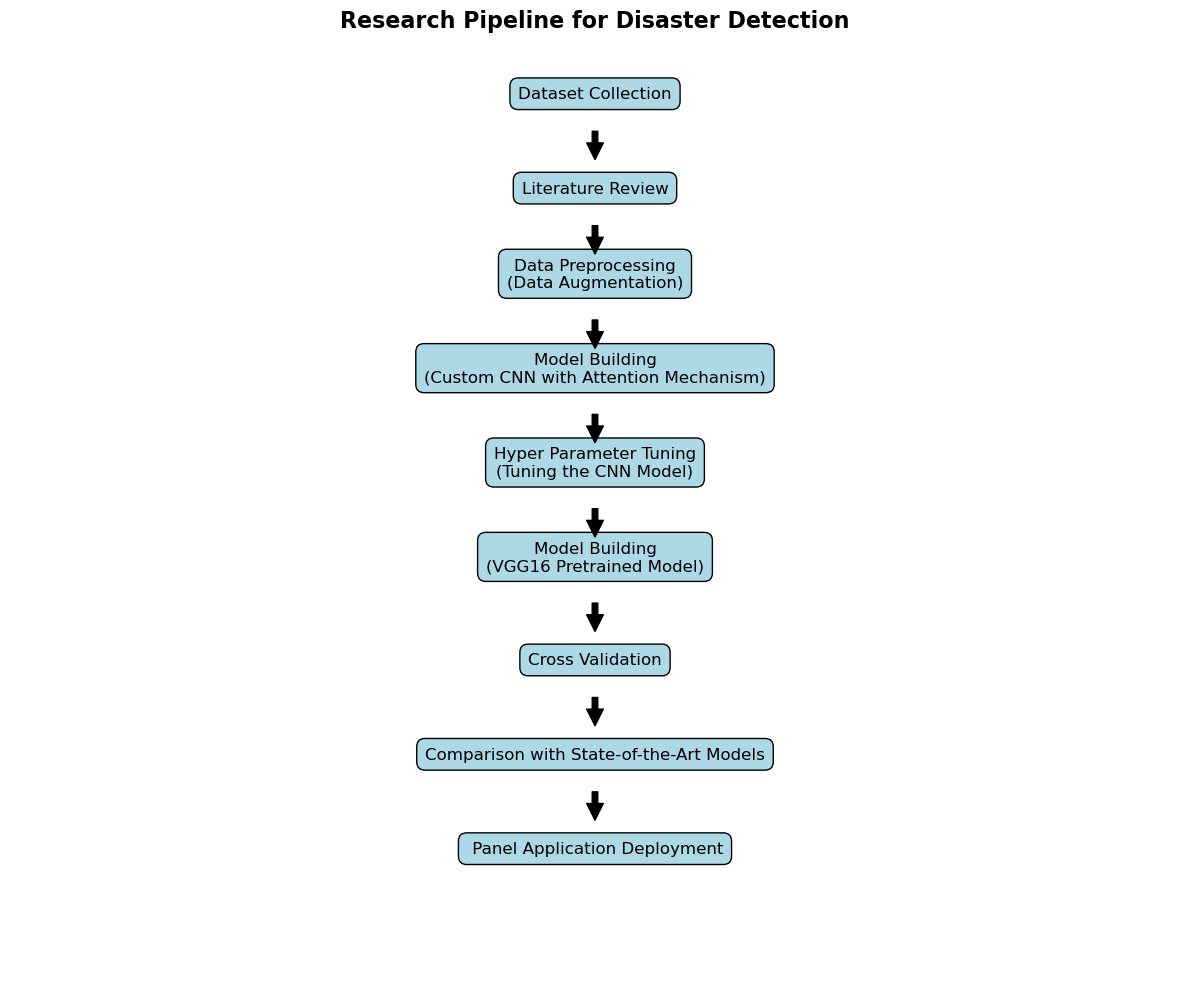

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 1)
ax.axis('off')

# Title
plt.title('Research Pipeline for Disaster Detection', fontsize=16, fontweight='bold')

# Define the steps in the pipeline
steps = [
    ("Dataset Collection", 0.90),
    ("Literature Review", 0.75),
    ("Data Preprocessing\n(Data Augmentation)", 0.60),
    ("Model Building\n(Custom CNN with Attention Mechanism)", 0.45),
    ("Hyper Parameter Tuning\n(Tuning the CNN Model)", 0.30),
    ("Model Building\n(VGG16 Pretrained Model)", 0.15),
    ("Cross Validation", 0),
    ("Comparison with State-of-the-Art Models", -0.15),
    (" Panel Application Deployment", -0.30)
]

# Add text boxes for each step
for step, y_position in steps:
    ax.text(0.5, y_position, step, fontsize=12,
            ha='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Draw arrows between steps
for i in range(len(steps) - 1):
    ax.annotate('', xy=(0.5, steps[i + 1][1] + 0.05), xytext=(0.5, steps[i][1] - 0.05),
                arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.savefig('research_pipeline_disaster_detection.png', bbox_inches='tight')
plt.show()

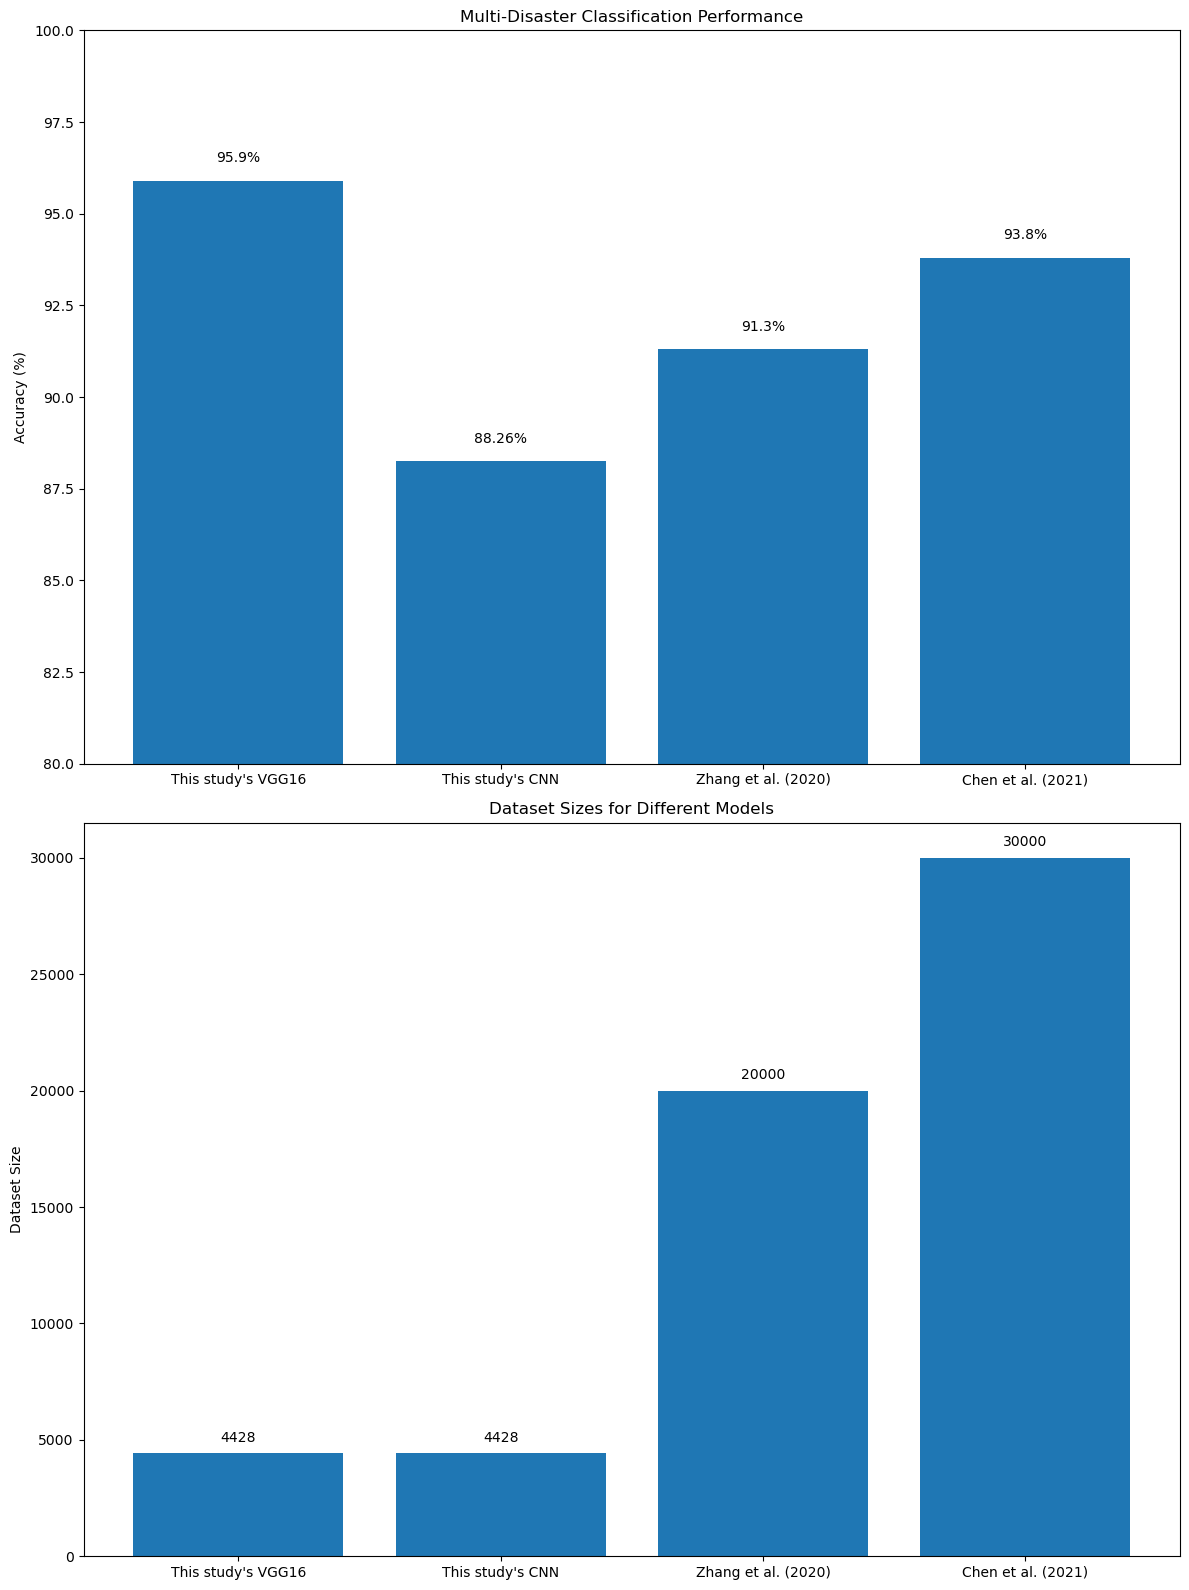

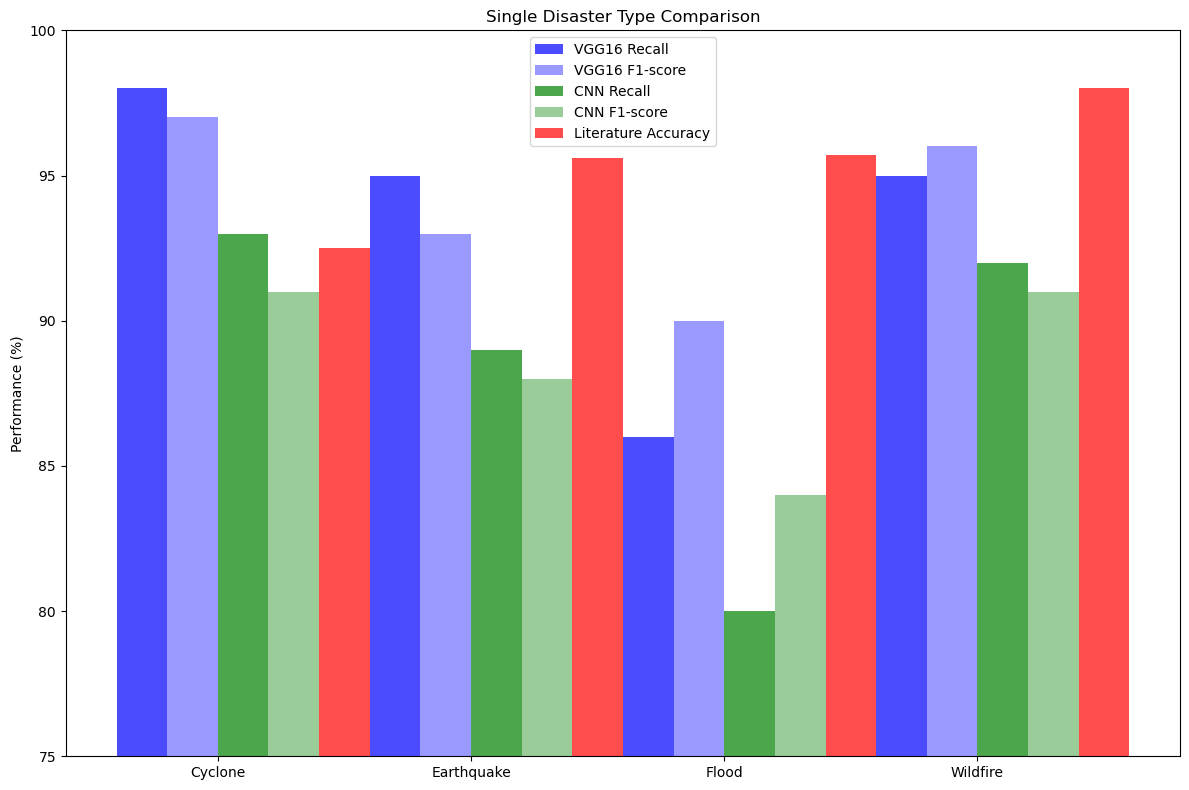

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Multi-Disaster Classification Performance
models = ['This study\'s VGG16', 'This study\'s CNN', 'Zhang et al. (2020)', 'Chen et al. (2021)']
accuracies = [95.90, 88.26, 91.3, 93.8]
dataset_sizes = [4428, 4428, 20000, 30000]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot accuracies
ax1.bar(models, accuracies)
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Multi-Disaster Classification Performance')
ax1.set_ylim(80, 100)

for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.5, f'{v}%', ha='center')

# Plot dataset sizes
ax2.bar(models, dataset_sizes)
ax2.set_ylabel('Dataset Size')
ax2.set_title('Dataset Sizes for Different Models')

for i, v in enumerate(dataset_sizes):
    ax2.text(i, v + 500, str(v), ha='center')

plt.tight_layout()

# Single Disaster Type Comparison
disaster_types = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
vgg16_recall = [98, 95, 86, 95]
vgg16_f1 = [97, 93, 90, 96]
cnn_recall = [93, 89, 80, 92]
cnn_f1 = [91, 88, 84, 91]
literature_accuracy = [92.5, 95.6, 95.7, 98]

x = np.arange(len(disaster_types))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(x - width*1.5, vgg16_recall, width, label='VGG16 Recall', color='b', alpha=0.7)
ax.bar(x - width/2, vgg16_f1, width, label='VGG16 F1-score', color='b', alpha=0.4)
ax.bar(x + width/2, cnn_recall, width, label='CNN Recall', color='g', alpha=0.7)
ax.bar(x + width*1.5, cnn_f1, width, label='CNN F1-score', color='g', alpha=0.4)
ax.bar(x + width*2.5, literature_accuracy, width, label='Literature Accuracy', color='r', alpha=0.7)

ax.set_ylabel('Performance (%)')
ax.set_title('Single Disaster Type Comparison')
ax.set_xticks(x)
ax.set_xticklabels(disaster_types)
ax.legend()
ax.set_ylim(75, 100)

plt.tight_layout()
plt.show()


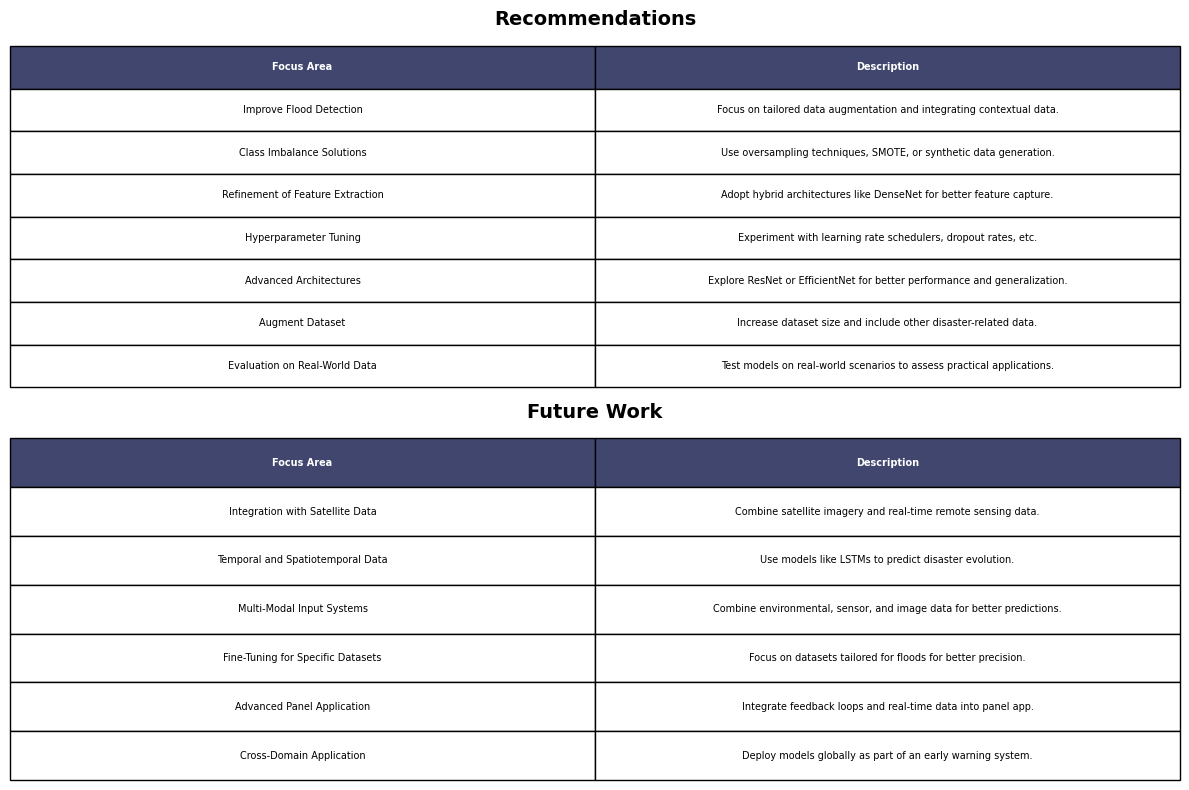

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Data for Recommendations
recommendations_data = [
    ["Improve Flood Detection", "Focus on tailored data augmentation and integrating contextual data."],
    ["Class Imbalance Solutions", "Use oversampling techniques, SMOTE, or synthetic data generation."],
    ["Refinement of Feature Extraction", "Adopt hybrid architectures like DenseNet for better feature capture."],
    ["Hyperparameter Tuning", "Experiment with learning rate schedulers, dropout rates, etc."],
    ["Advanced Architectures", "Explore ResNet or EfficientNet for better performance and generalization."],
    ["Augment Dataset", "Increase dataset size and include other disaster-related data."],
    ["Evaluation on Real-World Data", "Test models on real-world scenarios to assess practical applications."]
]

# Data for Future Work
future_work_data = [
    ["Integration with Satellite Data", "Combine satellite imagery and real-time remote sensing data."],
    ["Temporal and Spatiotemporal Data", "Use models like LSTMs to predict disaster evolution."],
    ["Multi-Modal Input Systems", "Combine environmental, sensor, and image data for better predictions."],
    ["Fine-Tuning for Specific Datasets", "Focus on datasets tailored for floods for better precision."],
    ["Advanced Panel Application", "Integrate feedback loops and real-time data into panel app."],
    ["Cross-Domain Application", "Deploy models globally as part of an early warning system."]
]

def plot_table(data, title, ax):
    table = Table(ax, bbox=[0, 0, 1, 1])
    columns = ["Focus Area", "Description"]

    # Header
    for col, header in enumerate(columns):
        cell = table.add_cell(0, col, width=0.5, height=0.15, text=header, loc='center')
        cell.set_facecolor('#40466e')
        cell.set_text_props(color='white', fontweight='bold')

    # Rows
    for i, row in enumerate(data):
        for j, cell_content in enumerate(row):
            cell = table.add_cell(i + 1, j, width=0.5, height=0.15, text=cell_content, loc='center')
            cell.set_text_props(fontsize=9)

    # Add table to plot
    ax.add_table(table)
    ax.axis('off')
    ax.set_title(title, fontsize=14, pad=15, weight='bold')
# Create subplots for tables
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot the tables
plot_table(recommendations_data, "Recommendations", axes[0])
plot_table(future_work_data, "Future Work", axes[1])

# Adjust layout
plt.tight_layout()
plt.show()

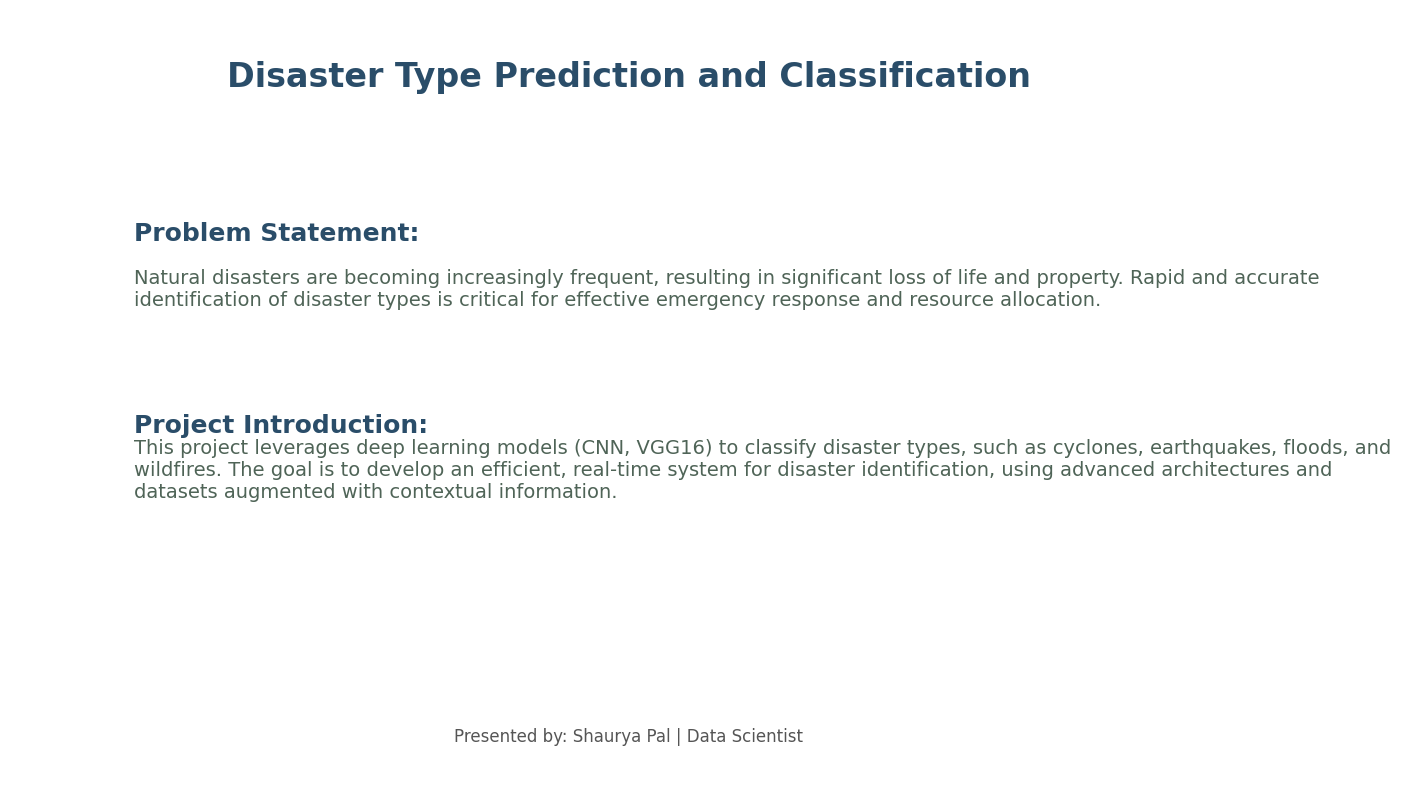

In [2]:
import matplotlib.pyplot as plt

# Define project details
project_title = "Disaster Type Prediction and Classification"
problem_statement = (
    "Natural disasters are becoming increasingly frequent, "
    "resulting in significant loss of life and property. "
    "Rapid and accurate identification of disaster types is critical "
    "for effective emergency response and resource allocation."
)
project_introduction = (
    "This project leverages deep learning models (CNN, VGG16) "
    "to classify disaster types, such as cyclones, earthquakes, floods, and wildfires. "
    "The goal is to develop an efficient, real-time system for disaster identification, "
    "using advanced architectures and datasets augmented with contextual information."
)

# Create the slide
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('off')

# Title
ax.text(
    0.5, 0.9, project_title, fontsize=24, fontweight='bold', ha='center', color="#2a4d69"
)

# Problem Statement
ax.text(
    0.1, 0.7, "Problem Statement:", fontsize=18, fontweight='bold', color="#2a4d69"
)
ax.text(
    0.1, 0.62, problem_statement, fontsize=14, wrap=True, color="#4f6457",
    ha='left', ma='left', transform=ax.transAxes
)

# Introduction
ax.text(
    0.1, 0.45, "Project Introduction:", fontsize=18, fontweight='bold', color="#2a4d69"
)
ax.text(
    0.1, 0.37, project_introduction, fontsize=14, wrap=True, color="#4f6457",
    ha='left', ma='left', transform=ax.transAxes
)

# Footer
ax.text(
    0.5, 0.05, "Presented by: Shaurya Pal | Data Scientist", fontsize=12,
    ha='center', color="#555555"
)

# Show the slide
plt.tight_layout()
plt.show()


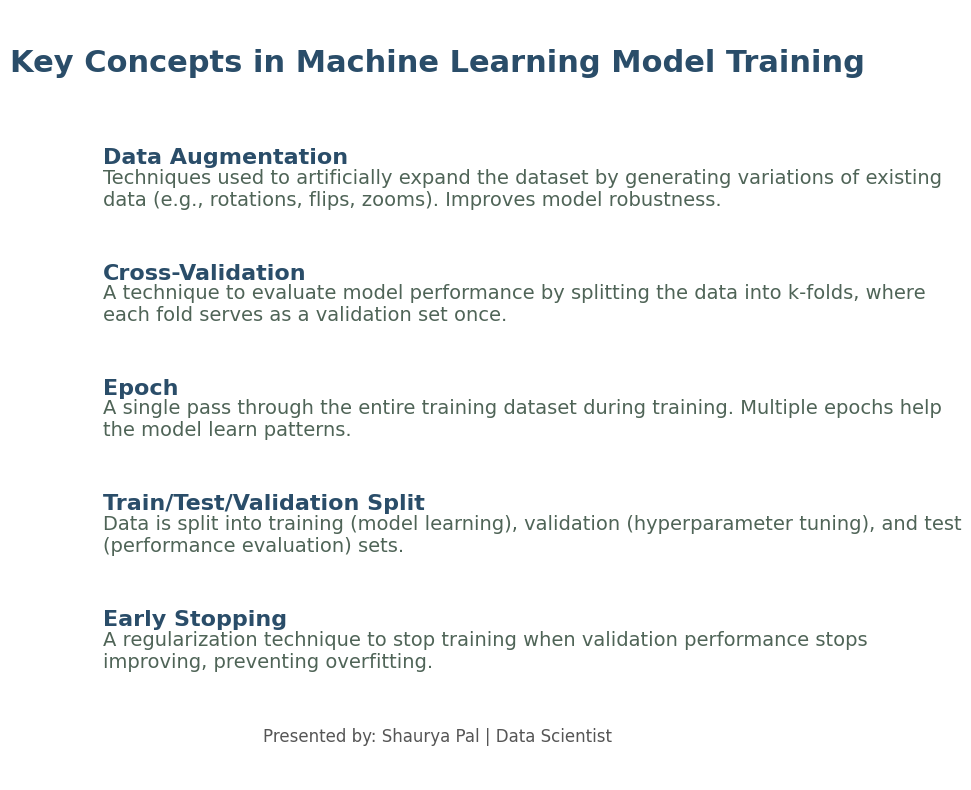

In [1]:
import matplotlib.pyplot as plt

# Define key concepts and explanations
concepts = [
    ("Data Augmentation", "Techniques used to artificially expand the dataset by generating variations of existing data (e.g., rotations, flips, zooms). Improves model robustness."),
    ("Cross-Validation", "A technique to evaluate model performance by splitting the data into k-folds, where each fold serves as a validation set once."),
    ("Epoch", "A single pass through the entire training dataset during training. Multiple epochs help the model learn patterns."),
    ("Train/Test/Validation Split", "Data is split into training (model learning), validation (hyperparameter tuning), and test (performance evaluation) sets."),
    ("Early Stopping", "A regularization technique to stop training when validation performance stops improving, preventing overfitting."),
]

# Create the slide
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')

# Title
ax.text(
    0.5, 0.92, "Key Concepts in Machine Learning Model Training", fontsize=22,
    fontweight='bold', ha='center', color="#2a4d69"
)

# Iterate through concepts and plot explanations
y_position = 0.8
for title, description in concepts:
    ax.text(
        0.1, y_position, title, fontsize=16, fontweight='bold', color="#2a4d69"
    )
    ax.text(
        0.1, y_position - 0.05, description, fontsize=14, wrap=True, color="#4f6457",
        ha='left', ma='left', transform=ax.transAxes
    )
    y_position -= 0.15  # Adjust position for the next item

# Footer
ax.text(
    0.5, 0.05, "Presented by: Shaurya Pal | Data Scientist", fontsize=12,
    ha='center', color="#555555"
)

# Show the slide
plt.tight_layout()
plt.show()
